## Sales data exploration and prediction using Machine Learning
[Gabriel Chen](mailto:gabriel.chen@sjsu.edu)<br>
[Soham Bhattacharjee](mailto:soham.bhattacharjee@sjsu.edu)<br>

### Objective
This machine learning model will go through historical sales data, and try to predict sale volume and manage inventory for hot selling products.

### Dataset
This project uses Google BigQuery public dataset for a ficticious e-commerce store.<br> Dataset Id: `bigquery-public-data.iowa_liquor_sales` <br>

The data gives indication of sales from each distribution center. <br>

*The key objective of this script is to predict which distribution center should add which product to inventory to meet future sales demand.*


### Imports

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

### Query Data from BigQuery

In [ ]:
%%bigquery df_sales --project cmpe-255-015443818 
select * from `bigquery-public-data.iowa_liquor_sales.sales` 
ORDER BY date DESC LIMIT 1000000

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df_sales.shape

(500000, 24)

In [ ]:
df_sales.to_csv('data.csv',index=False)

### Augmenting available data
This step will try to derive and add new features to the dataset, based on which we can train our model

#### Breaking down date column

In [ ]:
def date_features(df):
    # Date Features
    df['date'] = pd.to_datetime(df_sales['date'])
    df['year'] = df_sales.date.dt.year
    df['month'] = df_sales.date.dt.month
    df['day'] = df_sales.date.dt.day
    df['dayofyear'] = df_sales.date.dt.dayofyear
    df['dayofweek'] = df_sales.date.dt.dayofweek
    df['weekofyear'] = df_sales.date.dt.isocalendar().week
    
    return df

df_date_sales = date_features(df_sales)

In [ ]:
df_date_sales.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,year,month,day,dayofyear,dayofweek,weekofyear
0,INV-52625900008,2022-10-31,3918,SMOKIN' JOE'S #1 TOBACCO AND LIQUOR OUTLET,3120 ROCKINGHAM RD,DAVENPORT,52802.0,POINT(-90.621612 41.510043),None,SCOTT,...,24,110.64,9.00,2.37,2022,10,31,304,0,44
1,INV-52623300010,2022-10-31,4380,KUM & GO #254 / WEST BRANCH,620 S DOWNEY ST,WEST BRANCH,52358.0,POINT(-91.34675 41.66168),None,CEDAR,...,6,157.44,4.50,1.18,2022,10,31,304,0,44
2,INV-52621900025,2022-10-31,3920,SMOKIN' JOE'S #11 TOBACCO AND LIQUOR OUTLET,1606 CAMANCHE AVE,CLINTON,52732.0,POINT(-90.204131 41.828265),None,CLINTON,...,2,45.00,0.75,0.19,2022,10,31,304,0,44
3,INV-52616000008,2022-10-31,5736,218 FUEL EXPRESS,68 MONROE STREET,FLOYD,50435.0,POINT(-92.73738 43.122076),None,FLOYD,...,12,287.88,12.00,3.17,2022,10,31,304,0,44
4,INV-52586200076,2022-10-31,2647,HY-VEE #7 / CEDAR RAPIDS,5050 EDGEWOOD RD,CEDAR RAPIDS,52411.0,POINT(-91.701581 42.030129),None,LINN,...,6,76.44,10.50,2.77,2022,10,31,304,0,44


### Basic Exploratory Data Analysis

To explore the time series data first we need to aggregate the sales by day


In [ ]:
daily_sales = df_date_sales.groupby('date', as_index=False)['bottles_sold'].sum()
store_daily_sales = df_date_sales.groupby(['store_number', 'date'], as_index=False)['bottles_sold'].sum()
item_daily_sales = df_date_sales.groupby(['item_number', 'date'], as_index=False)['bottles_sold'].sum()

In [ ]:
#Overall daily sales
daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['bottles_sold'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

In [ ]:
#daily sales by distribution center
store_daily_sales_sc = []
for store in store_daily_sales['store_number'].unique():
    current_store_daily_sales = store_daily_sales[(store_daily_sales['store_number'] == store)]
    store_daily_sales_sc.append(go.Scatter(x=current_store_daily_sales['date'], y=current_store_daily_sales['bottles_sold'], name=('Store No %s' % store)))

layout = go.Layout(title='Store daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=store_daily_sales_sc, layout=layout)
iplot(fig)

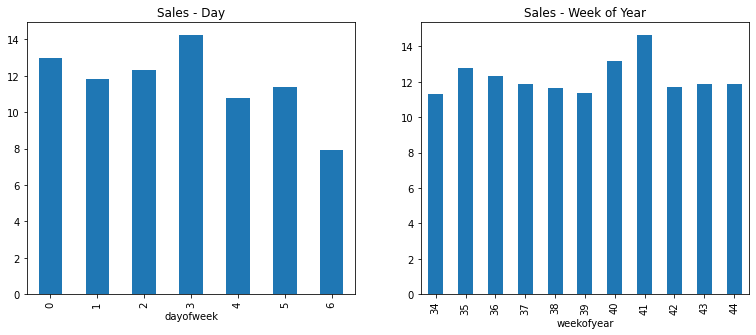

In [ ]:
data_grouped_day = df_date_sales.groupby(['dayofweek']).mean()['bottles_sold']
data_grouped_month = df_date_sales.groupby(['weekofyear']).mean()['bottles_sold']

plt.subplots(2,1, figsize=(20,5))
plt.subplot(131)
plt.title('Sales - Day')
data_grouped_day.plot(kind='bar', stacked=True)
plt.subplot(132)
plt.title('Sales - Week of Year')
data_grouped_month.plot(kind='bar', stacked=True)



### Models for predicting sales


In [ ]:
avg_sales = df_date_sales.groupby('date').agg({'bottles_sold': 'mean'}).reset_index()
avg_sales = avg_sales.set_index('date').to_period("D")
avg_sales['weekly_avg_sales'] = avg_sales['bottles_sold'].ewm(span=7, adjust=False).mean()

In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq='M', order=4)

dp = DeterministicProcess(
    index=avg_sales.index,
    constant=True,   # dummy feature for bias (y-intercept)
    order=1,         # trend ( order 1 means linear)
    seasonal=True,   # weekly seasonality (indicators)
    additional_terms=[fourier], # annual seasonality
    drop=True,       # drop terms to avoid collinearity
)

X = dp.in_sample() # create features for dates in tunnel.index

#### Prediction using Linear Regresion

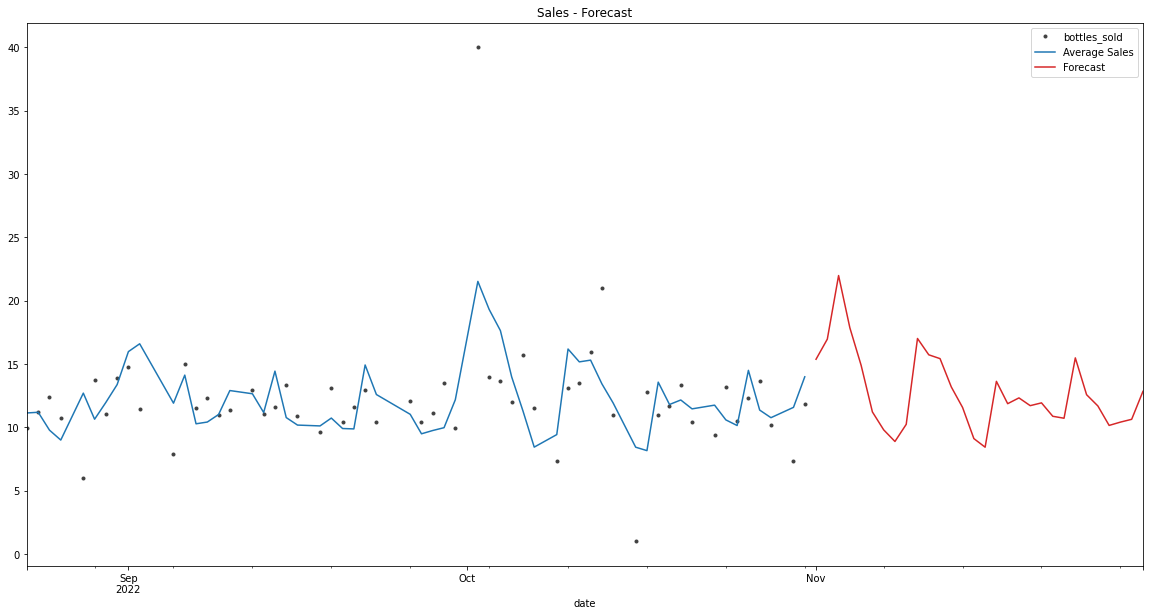

In [ ]:
from sklearn.linear_model import LinearRegression

y = avg_sales["bottles_sold"]


model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=30)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Sales - Forecast", figsize=[20,10])
ax = y_pred.plot(ax=ax, label="Average Sales")
ax = y_fore.plot(ax=ax, label="Forecast", color='C3')
_ = ax.legend()

### Predictions by Category

Text(0, 0.5, 'Transactions')

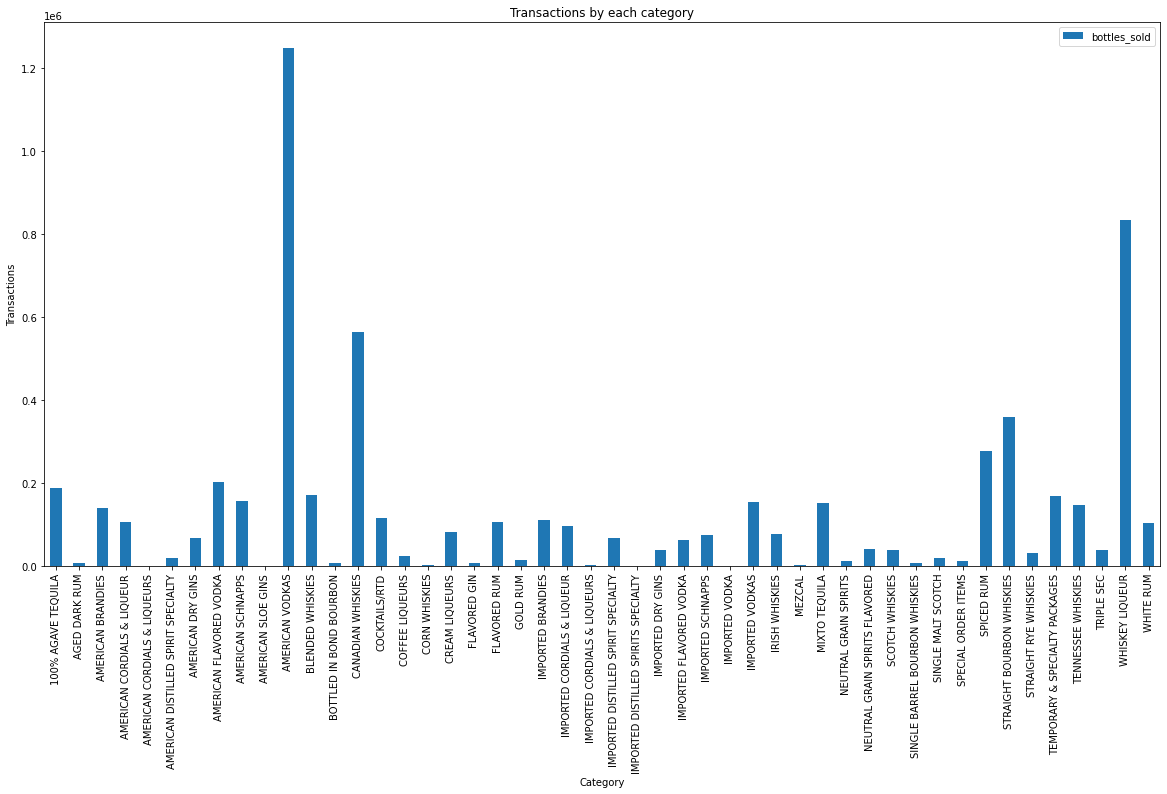

In [ ]:
# Count all sales by category and plot
sales_by_category = df_sales.groupby(['category_name']).agg({'bottles_sold':'sum'})
sales_by_category = sales_by_category.sort_index(ascending=[True])

sales_by_category.plot(kind='bar', figsize=[20,10])

plt.title("Transactions by each category")
plt.xlabel("Category")
plt.ylabel("Transactions")

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Implementing preprocessor
categorical_columns = ['month', 'store_number', 'category']

categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

preprocessor = ColumnTransformer(transformers=[
    ('categorical', categorical_transformer, categorical_columns)
])

In [ ]:
X_Dates = df_date_sales[df_date_sales['date']<'10-15-2022']
Test_Dates = df_date_sales[df_date_sales['date']>'10-16-2022']

y_train = X_Dates['bottles_sold'].astype('float32')
y_test = Test_Dates['bottles_sold'].astype('float32')
X_Dates = X_Dates.drop(['bottles_sold'], axis='columns')

In [ ]:
# Preprocessing data
X_train = preprocessor.fit_transform(X_Dates) 
X_test = preprocessor.transform(Test_Dates)

X_train = X_train.toarray()
X_test = X_test.toarray()

input_shape = X_train.shape[1]

In [ ]:
%pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.wrappers.scikit_learn import KerasRegressor
from xgboost import XGBRegressor
import lightgbm as ltb
import catboost as cb


# Modeling
model_dl = keras.Sequential([
    layers.BatchNormalization(input_shape=[input_shape]),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.15),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model_dl.compile(
    optimizer=optimizer,
    loss='mean_squared_error',
    metrics=['accuracy']
)

model_lgbm = ltb.LGBMRegressor()

model_catboost = cb.CatBoostRegressor(loss_function='RMSE')

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)

model_xgb = XGBRegressor()

In [ ]:
# Train
history = model_dl.fit(X_train, y_train,
          batch_size=512,
          epochs=5)

Epoch 1/5
761/761 [==============================] - 90s 116ms/step - loss: 1461.2922 - accuracy: 0.1046
Epoch 2/5
761/761 [==============================] - 75s 98ms/step - loss: 1366.2130 - accuracy: 0.1089
Epoch 3/5
761/761 [==============================] - 73s 96ms/step - loss: 1333.6396 - accuracy: 0.1088
Epoch 4/5
761/761 [==============================] - 73s 96ms/step - loss: 1300.7026 - accuracy: 0.1087
Epoch 5/5
761/761 [==============================] - 72s 94ms/step - loss: 1300.1941 - accuracy: 0.1089


In [ ]:
model_catboost.fit(X_train, y_train)

In [ ]:
model_lgbm.fit(X_train, y_train)

In [ ]:
model_xgb.fit(X_train, y_train)

In [ ]:
# Predicting 
results_catboost = model_catboost.predict(X_test)

results_lgbm = model_lgbm.predict(X_test)

results_dl = model_dl.predict(X_test)

results_xgb = model_xgb.predict(X_test)

In [ ]:
# Read results
results_catboost_df = pd.DataFrame(results_catboost)
results_lgbm_df = pd.DataFrame(results_lgbm)
results_dl_df = pd.DataFrame(results_dl)
results_xgb_df = pd.DataFrame(results_xgb)

In [ ]:
#Generate graph of predictions

ax_results = results_catboost_df.plot(color='0.25', figsize=[20,10]) 
results_lgbm_df.plot(ax=ax_results, label='LGBM Predictions', color='red')
results_dl_df.plot(ax=ax_results, label='MSE Predictions', color='green')
results_xgb_df.plot(ax=ax_results, label='XGB Predictions', color='cyan')
ax_results.legend()